# Bharat Ramchire (PGDA16)

The Deep learning project to predict the age, gender and ethnicity of a person using CNN algorithm

# dataset introduction

Age=Age of the person in the image

Ethnicity=Specifies the ethnicity of the person

Gender=Gender of the person
0=Male 1=Female

Pixels=Array to String of the image pixels

Importing required libraries

In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from keras.models import Sequential
from keras.layers import Conv2D, Dropout, BatchNormalization, Flatten, Dense, MaxPooling2D
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam

from sklearn.metrics import mean_absolute_error, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

Reading the data

In [4]:
data = pd.read_csv('/content/drive/MyDrive/Bharat python/age_gender.csv')

In [5]:
data.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


In [6]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,23705.0,33.300907,19.885708,1.0,23.0,29.0,45.0,116.0
ethnicity,23705.0,1.269226,1.345638,0.0,0.0,1.0,2.0,4.0
gender,23705.0,0.477283,0.499494,0.0,0.0,0.0,1.0,1.0


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        23705 non-null  int64 
 1   ethnicity  23705 non-null  int64 
 2   gender     23705 non-null  int64 
 3   img_name   23705 non-null  object
 4   pixels     23705 non-null  object
dtypes: int64(3), object(2)
memory usage: 926.1+ KB


In [8]:
data.isna().sum()

age          0
ethnicity    0
gender       0
img_name     0
pixels       0
dtype: int64

In [9]:
# Basic EDA and visualaization of the data

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


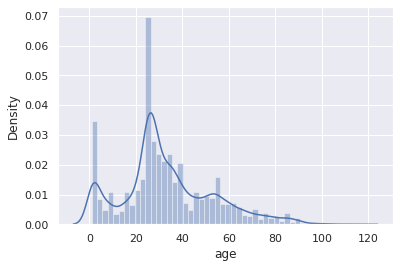

In [10]:
# Age
sns.distplot(data['age']);

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


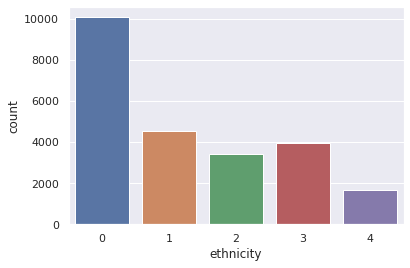

In [11]:
# Ethnicity
sns.countplot(data['ethnicity']);

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


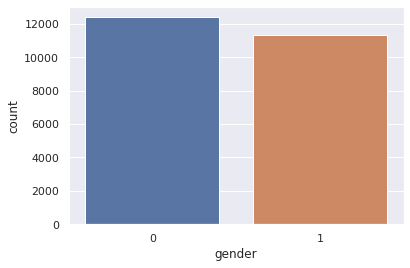

In [12]:
# Gender
sns.countplot(data['gender']);

In [13]:
import plotly.graph_objects as go

In [14]:
df_ethnicity=data['ethnicity'].value_counts().to_frame().reset_index().rename(columns={'index':'ethnicity','ethnicity':'count'})

colors=['cyan','royalblue','blue','darkblue',"darkcyan"]
fig = go.Figure([go.Pie(labels=df_ethnicity['ethnicity'], values=df_ethnicity['count'])])
fig.update_traces(hoverinfo='label+percent', textinfo='percent+value', textfont_size=15,
                 marker=dict(colors=colors, line=dict(color='#000000', width=2)))
fig.update_layout(title="Ethnicity Distribution",title_x=0.5)
fig.show()

Gender count

In [59]:
df_gender=data['gender'].value_counts().to_frame().reset_index().rename(columns={'index':'gender','gender':'count'})


fig = go.Figure([go.Pie(labels=df_gender['gender'], values=df_gender['count'])])
fig.update_layout(title="Gender Count",title_x=0.5)
fig.show()

Actually imaeges in dataset are in string format so transform it in more useful type of data.

In [17]:
data['pixels'] = data['pixels'].map(lambda x: np.array(x.split(' '), dtype=np.float32).reshape(48, 48))

In [18]:
# Plotting some pictures from the data

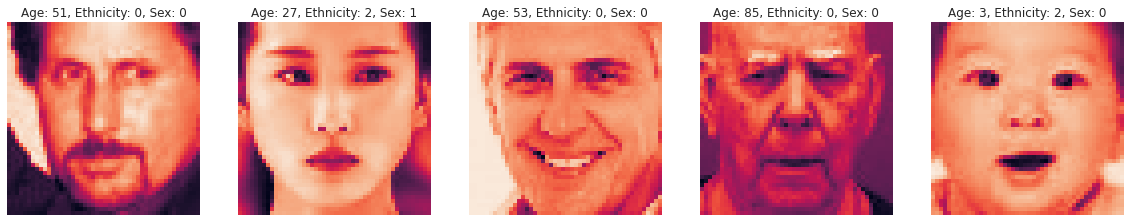

In [19]:
fig, axes = plt.subplots(1, 5, figsize=(20, 10))

for i in range(5):
    random_face = np.random.choice(len(data))
    
    age = data['age'][random_face]
    ethnicity = data['ethnicity'][random_face]
    gender = data['gender'][random_face]
    
    axes[i].set_title('Age: {0}, Ethnicity: {1}, Sex: {2}'.format(age, ethnicity, gender))
    axes[i].imshow(data['pixels'][random_face])
    axes[i].axis('off')

# Building the CNN model to predict the age, gender and ethnicity

In [20]:
# Reshape images for CNN
X = np.array(data['pixels'].to_list())
X_reshaped = X.reshape(X.shape[0], 48, 48, 1)

In [21]:
# Normalise images fromt he data
if np.max(X_reshaped) > 1: X_reshaped = X_reshaped / 255

In [22]:
# getting the some significant variables
input_shape = X_reshaped.shape[1:] 

n_epochs = 25
batch_size = 64

# Age prediction using CNN model

In [23]:
y = data['age'].values

In [24]:
# splitting the data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

In [25]:
# Building the model

age_model = Sequential()

age_model.add(Conv2D(64, kernel_size=(3,3), input_shape=input_shape, activation='relu'))
age_model.add(MaxPooling2D(pool_size=(2,2)))
age_model.add(BatchNormalization())

age_model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
age_model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
age_model.add(MaxPooling2D(pool_size=(2,2)))
age_model.add(Dropout(0.3))
age_model.add(BatchNormalization())

age_model.add(Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'))
age_model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
age_model.add(MaxPooling2D(pool_size=(2,2)))
age_model.add(Dropout(0.3))
age_model.add(BatchNormalization())

age_model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same'))
age_model.add(MaxPooling2D(pool_size=(2,2)))
age_model.add(Dropout(0.5))
age_model.add(BatchNormalization())

age_model.add(Flatten())
age_model.add(Dense(128, activation='relu'))
age_model.add(Dropout(0.4))
age_model.add(Dense(1))

age_model.compile(optimizer='adam', loss='mse')

age_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 23, 23, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 23, 23, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 10, 10, 128)       0

In [26]:
# Callbacks for age model
callbacks = [EarlyStopping(patience=4, monitor='val_loss', mode='min'), 
             ReduceLROnPlateau(patience=2, verbose=1)]

In [27]:
history = age_model.fit(X_train, y_train, 
                        epochs=n_epochs,
                        batch_size=batch_size,
                        callbacks=callbacks,
                        validation_data=(X_test, y_test))

Epoch 1/25
297/297 [==============================] - 41s 24ms/step - loss: 403.0047 - val_loss: 2833.4138
Epoch 2/25
297/297 [==============================] - 7s 22ms/step - loss: 151.8512 - val_loss: 2269.3228
Epoch 3/25
297/297 [==============================] - 7s 22ms/step - loss: 124.9945 - val_loss: 262.7137
Epoch 4/25
297/297 [==============================] - 7s 22ms/step - loss: 113.0531 - val_loss: 422.6773
Epoch 5/25
297/297 [==============================] - 7s 22ms/step - loss: 106.8203 - val_loss: 140.6148
Epoch 6/25
297/297 [==============================] - 7s 22ms/step - loss: 99.5947 - val_loss: 211.9046
Epoch 7/25
297/297 [==============================] - 7s 22ms/step - loss: 93.0037 - val_loss: 288.2183

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 8/25
297/297 [==============================] - 7s 22ms/step - loss: 77.6012 - val_loss: 69.1799
Epoch 9/25
297/297 [==============================] - 7s 22ms/step - loss: 71.9

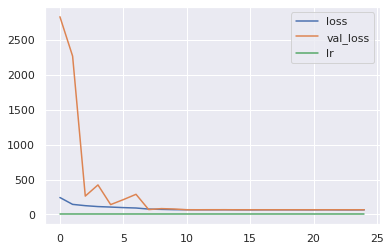

In [28]:
pd.DataFrame(history.history).plot();

In [29]:
# Make predictionson test data 
y_pred = age_model.predict(X_test)

In [30]:
# Mean absolute error
print("MAE: {}".format(mean_absolute_error(y_test, y_pred)))

MAE: 5.755795780678536


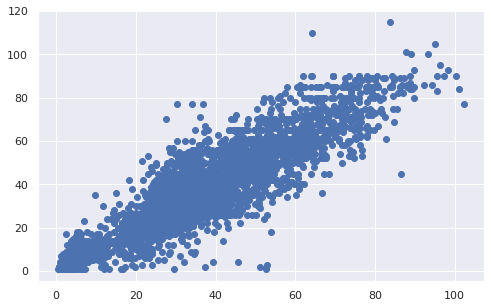

In [31]:
# Distribution of the data
plt.figure(figsize=(8, 5))
plt.scatter(y_pred, y_test);

So, mean absolute error around 5.5 years it's not so super result considering mean age is 33

# Gender prediction

In [32]:
y = data['gender'].values

# splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

In [33]:
# Building the model

gender_model = Sequential()

gender_model.add(Conv2D(64, kernel_size=(3,3), input_shape=input_shape, activation='relu'))
gender_model.add(MaxPooling2D(pool_size=(2,2)))
gender_model.add(BatchNormalization())

gender_model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
#gender_model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
gender_model.add(MaxPooling2D(pool_size=(2,2)))
gender_model.add(Dropout(0.4))
gender_model.add(BatchNormalization())

gender_model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
gender_model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
gender_model.add(MaxPooling2D(pool_size=(2,2)))
gender_model.add(Dropout(0.5))
gender_model.add(BatchNormalization())

gender_model.add(Flatten())

gender_model.add(Dense(64, activation='relu'))
gender_model.add(Dropout(0.4))

gender_model.add(Dense(1, activation='sigmoid')) #For binary classification activation function is sigmoid 

gender_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) #...and loss function is binary_crossentropy

gender_model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 46, 46, 64)        640       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 23, 23, 64)        256       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 21, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 10, 10, 128)       0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 10, 10, 128)      

In [34]:
# Callbacks for gender model
callbacks = [EarlyStopping(patience=4, monitor='val_accuracy', mode='max'), 
              ReduceLROnPlateau(patience=2, verbose=1)]

In [35]:
history = gender_model.fit(X_train, y_train, 
                           epochs=n_epochs,
                           batch_size=batch_size,
                           callbacks=callbacks,
                           validation_data=(X_test, y_test))

Epoch 1/25
297/297 [==============================] - 6s 16ms/step - loss: 0.6078 - accuracy: 0.6995 - val_loss: 0.5843 - val_accuracy: 0.6537
Epoch 2/25
297/297 [==============================] - 4s 15ms/step - loss: 0.3634 - accuracy: 0.8361 - val_loss: 0.3418 - val_accuracy: 0.8502
Epoch 3/25
297/297 [==============================] - 4s 15ms/step - loss: 0.3109 - accuracy: 0.8559 - val_loss: 0.3431 - val_accuracy: 0.8376
Epoch 4/25
297/297 [==============================] - 4s 15ms/step - loss: 0.2851 - accuracy: 0.8688 - val_loss: 0.2698 - val_accuracy: 0.8821
Epoch 5/25
297/297 [==============================] - 4s 15ms/step - loss: 0.2696 - accuracy: 0.8791 - val_loss: 0.2660 - val_accuracy: 0.8821
Epoch 6/25
297/297 [==============================] - 4s 15ms/step - loss: 0.2564 - accuracy: 0.8881 - val_loss: 0.2837 - val_accuracy: 0.8768
Epoch 7/25
297/297 [==============================] - 4s 15ms/step - loss: 0.2422 - accuracy: 0.8949 - val_loss: 0.2635 - val_accuracy: 0.8884

In [36]:
# Metrics evaluation
valid_score = gender_model.evaluate(X_test, y_test, verbose=1)
print('Accuracy for test set: {0}'.format(valid_score[1]))

149/149 [==============================] - 1s 4ms/step - loss: 0.2390 - accuracy: 0.9108
Accuracy for test set: 0.9107783436775208


In [37]:
y_pred = gender_model.predict_classes(X_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning:

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).



In [38]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.91      0.91      2468
           1       0.90      0.91      0.91      2273

    accuracy                           0.91      4741
   macro avg       0.91      0.91      0.91      4741
weighted avg       0.91      0.91      0.91      4741



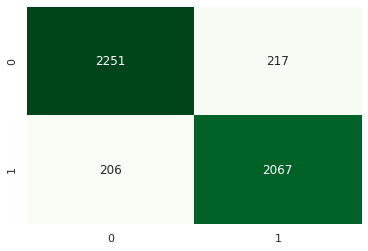

In [39]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='Greens', cbar=False, annot=True, fmt='d');

Due to the more no of childern the model giving the less accuracy in prediction. Let's see some examples where's model had made mistake

In [40]:
y_pred = y_pred.reshape(y_pred.shape[0])


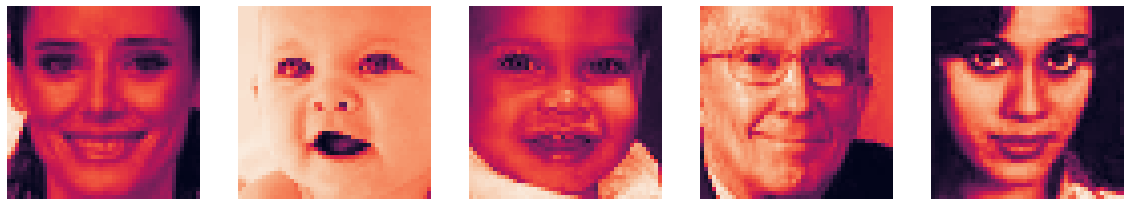

In [41]:
# Model predict is female, but actually it's male

X_fp = X_test[(y_pred == 1) & (y_test == 0)] 

fig, axes = plt.subplots(1, 5, figsize=(20, 10))

for i in range(5):
    
    random_choice = np.random.choice(len(X_fp))
    
    axes[i].imshow(X_fp[random_choice].reshape(48, 48))
    axes[i].axis('off')

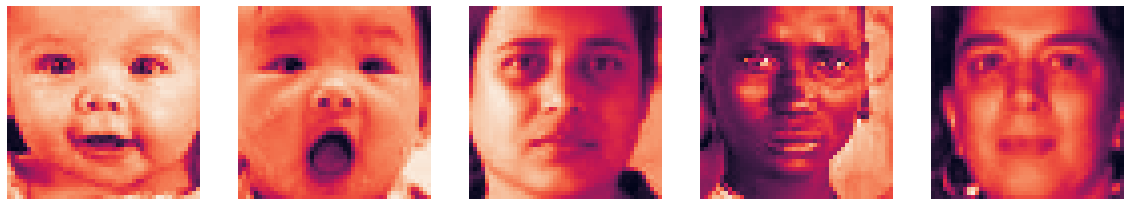

In [42]:
# Model predict is male, but actually it's female

X_fn = X_test[(y_pred == 0) & (y_test == 1)]  

fig, axes = plt.subplots(1, 5, figsize=(20, 10))

for i in range(5):
    
    random_choice = np.random.choice(len(X_fn))
    axes[i].imshow(X_fn[random_choice].reshape(48, 48))
    axes[i].axis('off')

# Ethnicity prediction

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
y = data['ethnicity'].values

# Multiclass problem transform to one_hot_encoding
y = to_categorical(y, 5)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

In [45]:
eth_model = Sequential()

eth_model.add(Conv2D(64, kernel_size=(3,3), input_shape=input_shape, activation='relu'))
eth_model.add(MaxPooling2D(pool_size=(2,2)))
eth_model.add(BatchNormalization())

eth_model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
eth_model.add(MaxPooling2D(pool_size=(2,2)))
eth_model.add(BatchNormalization())

eth_model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
eth_model.add(MaxPooling2D(pool_size=(2,2)))
eth_model.add(Dropout(0.5))
eth_model.add(BatchNormalization())

eth_model.add(Flatten())
eth_model.add(Dense(128, activation='relu'))
eth_model.add(Dropout(0.5))
eth_model.add(Dense(5, activation='softmax')) #For multiclass classification activation function is softmax 

eth_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) #...and loss function is categorical_crossentropy

eth_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 46, 46, 64)        640       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 23, 23, 64)        256       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 21, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 10, 10, 128)       512       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 8, 8, 256)        

In [46]:
# Callbacks for ethnicity model
callbacks = [EarlyStopping(patience=4, monitor='val_accuracy', mode='max'), 
             ReduceLROnPlateau(patience=2, verbose=1)]

In [47]:
history = eth_model.fit(X_train, y_train, 
                         epochs=n_epochs,
                         batch_size=batch_size,
                         callbacks=callbacks,
                         validation_data=(X_test, y_test))

Epoch 1/25
297/297 [==============================] - 5s 14ms/step - loss: 1.4283 - accuracy: 0.4951 - val_loss: 3.4435 - val_accuracy: 0.4318
Epoch 2/25
297/297 [==============================] - 4s 13ms/step - loss: 0.9092 - accuracy: 0.6847 - val_loss: 1.3795 - val_accuracy: 0.5514
Epoch 3/25
297/297 [==============================] - 4s 13ms/step - loss: 0.8234 - accuracy: 0.7143 - val_loss: 0.7131 - val_accuracy: 0.7517
Epoch 4/25
297/297 [==============================] - 4s 13ms/step - loss: 0.7535 - accuracy: 0.7364 - val_loss: 0.8288 - val_accuracy: 0.6868
Epoch 5/25
297/297 [==============================] - 4s 13ms/step - loss: 0.6928 - accuracy: 0.7598 - val_loss: 0.7145 - val_accuracy: 0.7477

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 6/25
297/297 [==============================] - 4s 13ms/step - loss: 0.6205 - accuracy: 0.7867 - val_loss: 0.5850 - val_accuracy: 0.7933
Epoch 7/25
297/297 [==============================] - 4s 13m

In [48]:
valid_score = eth_model.evaluate(X_test, y_test, verbose=1)

149/149 [==============================] - 1s 4ms/step - loss: 0.5539 - accuracy: 0.8104


In [49]:
y_pred = eth_model.predict_classes(X_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning:

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).



In [50]:
# Convert to 0 to 4 scale 
y_test_labels = [np.argmax(i) for i in y_test]

In [51]:
print(classification_report(y_test_labels, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86      2047
           1       0.85      0.85      0.85       904
           2       0.85      0.86      0.86       657
           3       0.73      0.78      0.75       804
           4       0.48      0.12      0.19       329

    accuracy                           0.81      4741
   macro avg       0.75      0.70      0.70      4741
weighted avg       0.79      0.81      0.79      4741



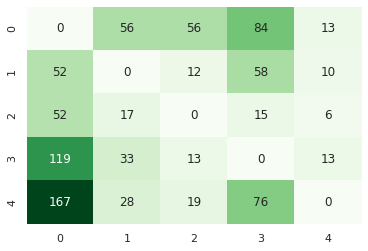

In [52]:
# Confusion matrix
cm = confusion_matrix(y_test_labels, y_pred)

np.fill_diagonal(cm, 0) #Fill diagonal with 0 for better visualisation
sns.heatmap(cm, annot=True, fmt='d', cbar=False, cmap='Greens');

In [53]:
def face_prediction(image):
    
    x = image.reshape(1, 48, 48, 1)
    x = x / 255
    
    age_predict = int(age_model.predict(x))
    gender_predict = int(gender_model.predict_classes(x))
    ethnicity_predict = int(eth_model.predict_classes(x))
    
    gender = {0: 'Male', 1: 'Female'}
    eth_group = {0: 'White', 1: 'Black', 2: 'Asian', 3: 'Indian', 4: 'Other'} 
    plt.imshow(image)
    plt.title('{0}, {1}, {2}'.format(age_predict, gender[gender_predict], eth_group[ethnicity_predict]))
    plt.axis('off')

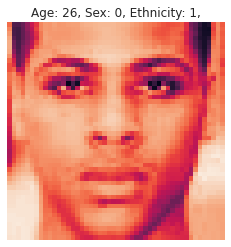

In [55]:
# Final check
random_face = np.random.choice(len(data))

age = data['age'][random_face]
ethnicity = data['ethnicity'][random_face]
gender = data['gender'][random_face]

plt.imshow(data['pixels'][random_face])
plt.title('Age: {0}, Sex: {1}, Ethnicity: {2},'.format(age, gender, ethnicity))
plt.axis('off');

In [56]:
# the prediction of the age gender and ethnicity by the CNN model

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning:

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).



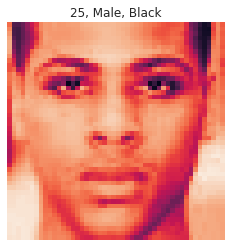

In [57]:
face_prediction(data['pixels'][random_face])